# Sparkify: Music Streaming App Big Data Analytics

Sparkify is a fictional music streaming service. Like any product-based company, retaining existing customers is of prime importance as it is easier and cheaper to retain existing users than it is to acquire new users. Thus, here I analyze big data containing user log to perform churn analytics using feature engineering & analytics using Apache Spark Python Spark API, pySpark. 


# Setup Environment

In [2]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 204.7MB 70kB/s 
     |████████████████████████████████| 204kB 33.6MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=ed69a4fe8b6904232a6dad86f005438edaaebf0b8d507c9d54016b87406e4950
  Stored in directory: /root/.cache/pip/wheels/57/27/4d/ddacf7143f8d5b76c45c61ee2e43d9f8492fc5a8e78ebd7d37
Successfully built pyspark
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 35.8 MB of archives.
After this 

In [44]:
import numpy as np
import pandas as pd

import re
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
from pyspark.sql.functions import isnan, when, count, col, isnull, udf, last, first, struct, lit, approx_count_distinct
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import when as Fwhen
from pyspark.sql.functions import lag as Flag
from pyspark.sql.functions import isnull as Fisnull
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.feature import StringIndexer, MinMaxScaler, VectorAssembler
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml.classification import LogisticRegressionModel, GBTClassificationModel, RandomForestClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Analytics") \
    .getOrCreate()

# Load and Clean Dataset


In [6]:
user_log = spark.read.json("drive/My Drive/Colab Notebooks/sparkify_event_data.json")
user_log.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [7]:
print("The dimension of the dataframe is", user_log.count()," x ", len(user_log.columns))

The dimension of the dataframe is 286500  x  18


In [10]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## Removing NaN & Missing Values

Remove logs containing null userId or sessionId

In [8]:
# Used both isnan and isnull PySpark SQL functions as suggested at 
user_log.select([count(when(isnan(c), c)).alias(c) for c in user_log.columns]).show()
user_log.select([count(when(isnull(c), c)).alias(c) for c in user_log.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAge

In [9]:
# If no first name we would expect users not to be registered and hence to have no user ID
user_log.filter(isnull(user_log.firstName)).select('registration').dropDuplicates().show()
user_log.filter(isnull(user_log.firstName)).select('userId').dropDuplicates().show()


+------------+
|registration|
+------------+
|        null|
+------------+

+------+
|userId|
+------+
|      |
+------+



It turns out that there are two cases of missing values:
8346 rows of unregistered users (the "userId" column is empty and there is no personal user information, i.e. first/ last name and gender available)

It seems reasonable to simply drop these rows since we only care about the churn of existing users. On the other side, song data can be missing as a user might just be browsing and is ignored for our analysis.

In [10]:
user_log = user_log.filter((user_log.userId!="") | (user_log.sessionId!=""))

## Exploratory Data Analysis


Let's see how much the data has changed post cleaning. The objective is to get a better understanding of the users the data is representing. 

In [14]:
num_rows = user_log.count()
num_cols = len(user_log.columns)
print('Number of rows: {0}\nNumber of columns: {1}'.format(num_rows, num_cols))


Number of rows: 278154
Number of columns: 27


We noticed that close to 10k entries were eliminated. Now, we have to find the number of interactions per user to understand how many user points are we dealing with.

In [15]:
num_users = user_log.select('userId').dropDuplicates().count()
print('Number of unique users: {0}\nAverage number of interactions per user {1}'.format(num_users, (num_rows/num_users)))

Number of unique users: 225
Average number of interactions per user 1236.24


* While there are 278,154 interactions, this data at the end represents really just data of 225 unique users.

* This means that to prepare the data for modeling, we have to aggregate the user log data into one row per user. 

### Explore the distribution of interaction 

Median number of interactions per user: 848.0
Standard deviation of interactions per user: 1329.5317164325195
Minimum number of interactions for a single user: 6
Maximum number of interactions for a single user: 9632


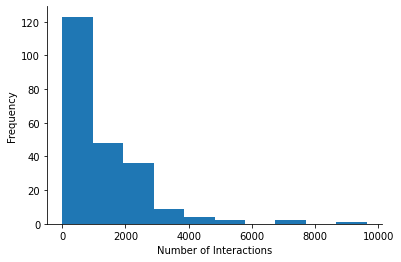

In [16]:
# Create a pandas dataframe with the distribution of the number of interactions and plot it
interactions_df = user_log.groupBy('userId').count().toPandas()
interactions_df.plot.hist(sns.color_palette()[0], legend = None)
plt.xlabel('Number of Interactions')
sns.set(style="ticks")
sns.despine(right=True,top=True)
plt.savefig('sparkify_num_interactions.png', dpi = 300)
print('Median number of interactions per user: {}'.format(interactions_df['count'].median()))
print('Standard deviation of interactions per user: {}'.format(interactions_df['count'].std()))
print('Minimum number of interactions for a single user: {}'.format(interactions_df['count'].min()))
print('Maximum number of interactions for a single user: {}'.format(interactions_df['count'].max()))

We can see that there is quite a lot of variability with respect to the number of interactions per user. This was probably to be expected. There will usually be some users who won't use a service too much while others may actually be power users. As long as we have at least some interactions for each user and as long as this difference in usage intensity is later on somehow reflected in our features, we will probably be fine.


### Define Churn

Churn is defined as users who cancel the service and churn out of the service. Thus, cancellation confirmation events are used to define churn for both paid and free users.

As highlighted earlier, losing customers altogether is a more severe econmoic damage as compared to downgrade of serivce. Thus, we only look at users who completely stopped using the service.

Finally, strictly speaking defining churn by just accounting for users who have canceled their account will quite likely underestimate actual churn rates. There may be users who perhaps never used the paid service and who stopped using the service, but never bothered to cancel their registration. Given that the data we have here only covers about two months, it is probably not reasonable to try to cover this problem, but it is certainly a point worth keeping in mind.



In [17]:
# Identify users who canceled their registration
flag_cancel = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
user_log = user_log.withColumn('cancel_page',flag_cancel('page'))
windowval = Window.partitionBy('userId')
user_log = user_log.withColumn('churned',Fsum('cancel_page').over(windowval))

In [18]:
# Check if values of churned column are as expected, i.e. either 0 or 1
user_log.select('churned').dropDuplicates().show()

+-------+
|churned|
+-------+
|      0|
|      1|
+-------+



In [19]:
# Have a look at how many users have churned and how many have not
print('Number of users who have churned {}'.\
      format(user_log.filter(user_log.churned == 1).select('userId').dropDuplicates().count()))
print('Number of users who have not churned {}'.\
      format(user_log.filter(user_log.churned == 0).select('userId').dropDuplicates().count()))

Number of users who have churned 52
Number of users who have not churned 173


### Explore Data: Comparing Churners & Non-Churners

We can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

I decided to look at the following aggregated metrics:
* the total number of sessions of each user
* the average length of a user's sessions
* the total number of unique artists a user has listened to
* the average number of songs listened to during a session
* the average number of songs added to a playlist
* the average number of friends added during a session
* the average number of thumbs ups during a session
* users' gender
* users' state
* the difference between a user's date of registration and their last recorded activity as an indicator of how long they have used the service (total usage length)

#### Total Number of Sessions for Each User

In [20]:
prev_val_window = Window.partitionBy('userId').orderBy('ts')
user_log = user_log.withColumn('sessionId_prev',Flag(user_log.sessionId).over(prev_val_window))


# create column 'new_session' (0 or 1)
new_session = udf(lambda session_ids: 1 if (session_ids[0] != session_ids[1]) & (session_ids[0] is not None) else 0, 
                  IntegerType())
# Create column indicating whether the session ID is new and also set it to 1 for the first session ID for
# each user which is the only case where the previous session ID column will have a value of null
user_log = user_log.withColumn('new_session',Fwhen(Fisnull(user_log.sessionId_prev), 1).\
                                                      otherwise(new_session(struct('sessionId_prev','sessionId'))))

# Obtain total number of sessions for each user
user_log = user_log.withColumn('sessions_num', Fsum('new_session').over(windowval))
user_log.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', song_flag=1, home_flag=0, thumbs_up_flag=0, thumbs_down_flag=0, add_playlist_flag=0, add_friend_flag=0, settings_flag=0, help_flag=0, error_flag=0, cancel_page=0, churned=0, sessionId_prev=None, new_session=1, sessions_num=7)

#### Average Session Length

In [21]:
# Create Column containing timestamp from previous row
user_log = user_log.withColumn('ts_prev',Flag(user_log.ts).over(prev_val_window))


# Calculate time elapsed since previous row in minutes using UDF only within sessions and not between them, i.e. only
# when the session ID is not different from the previous row
timedelta_udf = udf(lambda x: ((datetime.fromtimestamp(x[1]/1000) - datetime.fromtimestamp(x[0]/1000)).\
                    total_seconds()/60) if (x[0] is not None)&(x[2] != 1) else 0, DoubleType())
user_log = user_log.withColumn('ts_delta',Fwhen(Fisnull(user_log.ts_prev), 0).\
                               otherwise(timedelta_udf(struct('ts_prev','ts','new_session'))))

# Sum up total length of all sessions for each user
user_log = user_log.withColumn('total_time_sessions',Fsum('ts_delta').over(windowval))

# Calculate average length of sessions
avg_time = udf(lambda x: x[0] / x[1], DoubleType())
user_log = user_log.withColumn('avg_session_lgth', avg_time(struct('total_time_sessions','sessions_num')))
user_log.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', song_flag=1, home_flag=0, thumbs_up_flag=0, thumbs_down_flag=0, add_playlist_flag=0, add_friend_flag=0, settings_flag=0, help_flag=0, error_flag=0, cancel_page=0, churned=0, sessionId_prev=None, new_session=1, sessions_num=7, ts_prev=None, ts_delta=0.0, total_time_sessions=1081.3833333333334, avg_session_lgth=154.48333333333335)

#### Average Numbers of Activity Per Session

In [22]:
# Define a UDF to subsequently create a new column indicating that a user performed an activity
flag_activity = udf(lambda column, activity: 1 if (column == activity) else 0, IntegerType())

# Create list containing names of new  flag columns to be created
flag_cols = ['song', 'home', 'thumbs_up', 'thumbs_down', 'add_playlist', 'add_friend', 'settings', 'help', 'error']
activities_list = ['NextSong','Home', 'Thumbs Up', 'Thumbs Down', 'Add to Playlist','Add Friend', 'Settings', 'Help', 'Error']

# Create the respective flag columns and calculate sums
# to pass in parameter to udf by defining a column containing a constant value -> lit(activity)
for activity,col_name in zip(activities_list, flag_cols):
    user_log = user_log.withColumn(col_name+'_flag', flag_activity('page', lit(activity)))

for col in flag_cols:    
    user_log = user_log.withColumn(col+'_num', Fsum(col+'_flag').over(windowval))

avg_per_session = udf(lambda numbers: numbers[0] / numbers[1], DoubleType())
    
for col in flag_cols:
    user_log = user_log.withColumn(col+'_avg_session', avg_per_session(struct(col+'_num', 'sessions_num')))

user_log.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', song_flag=1, home_flag=0, thumbs_up_flag=0, thumbs_down_flag=0, add_playlist_flag=0, add_friend_flag=0, settings_flag=0, help_flag=0, error_flag=0, cancel_page=0, churned=0, sessionId_prev=None, new_session=1, sessions_num=7, ts_prev=None, ts_delta=0.0, total_time_sessions=1081.3833333333334, avg_session_lgth=154.48333333333335, song_num=275, home_num=11, thumbs_up_num=17, thumbs_down_num=5, add_playlist_num=7, add_friend_num=4, settings_num=0, help_num=2, error_num=0, s

#### Total Usage Length

In [24]:
window_level = Window.partitionBy("userId").orderBy("ts").rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
user_log = user_log.withColumn('last_ts',last('ts').over(window_level))

# Define a UDF to calculate the difference in fractions of days between registration date and last date for which activity
# was observed
ts_diff_days = (lambda ts_struct: (datetime.fromtimestamp(ts_struct[1]/1000) - datetime.fromtimestamp(ts_struct[0]/1000)).\
                         total_seconds()/(24*3600))
ts_diff_udf = udf(ts_diff_days, DoubleType())

user_log = user_log.withColumn('usage_length',ts_diff_udf(struct('registration','last_ts')))
user_log.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', song_flag=1, home_flag=0, thumbs_up_flag=0, thumbs_down_flag=0, add_playlist_flag=0, add_friend_flag=0, settings_flag=0, help_flag=0, error_flag=0, cancel_page=0, churned=0, sessionId_prev=None, new_session=1, sessions_num=7, ts_prev=None, ts_delta=0.0, total_time_sessions=1081.3833333333334, avg_session_lgth=154.48333333333335, song_num=275, home_num=11, thumbs_up_num=17, thumbs_down_num=5, add_playlist_num=7, add_friend_num=4, settings_num=0, help_num=2, error_num=0, s

#### Unique Number of Artists

In [23]:
user_log = user_log.withColumn('dist_num_artists', approx_count_distinct('artist').over(windowval))
user_log.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', song_flag=1, home_flag=0, thumbs_up_flag=0, thumbs_down_flag=0, add_playlist_flag=0, add_friend_flag=0, settings_flag=0, help_flag=0, error_flag=0, cancel_page=0, churned=0, sessionId_prev=None, new_session=1, sessions_num=7, ts_prev=None, ts_delta=0.0, total_time_sessions=1081.3833333333334, avg_session_lgth=154.48333333333335, song_num=275, home_num=11, thumbs_up_num=17, thumbs_down_num=5, add_playlist_num=7, add_friend_num=4, settings_num=0, help_num=2, error_num=0, s

#### User Location

In [26]:
# Create a column containing the state a user resides in
extract_state = udf(lambda location: location[-2:])
user_log = user_log.withColumn('state', extract_state('location'))
user_log = user_log.withColumn('num_states', approx_count_distinct('state').over(windowval))
print(user_log.head())
# Check if the number of unique values of the states is indeed just 1 for each user
user_log.select('num_states').dropDuplicates().show()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', song_flag=1, home_flag=0, thumbs_up_flag=0, thumbs_down_flag=0, add_playlist_flag=0, add_friend_flag=0, settings_flag=0, help_flag=0, error_flag=0, cancel_page=0, churned=0, sessionId_prev=None, new_session=1, sessions_num=7, ts_prev=None, ts_delta=0.0, total_time_sessions=1081.3833333333334, avg_session_lgth=154.48333333333335, song_num=275, home_num=11, thumbs_up_num=17, thumbs_down_num=5, add_playlist_num=7, add_friend_num=4, settings_num=0, help_num=2, error_num=0, s

In [25]:
# Create function to make plots to compare distributions of different features across the two groups
# y-axis labels are displayed as percentages using approach found at 
# https://stackoverflow.com/questions/51473993/plot-an-histogram-with-y-axis-as-percentage-using-funcformatter
def plot_features(cols, num_rows, df_1, df_2, x_inc_list, y_max_list, y_inc_list, title_list):
    '''
    Plots histograms of features in two dataframes df_1 and df_2 from the columns defined in cols variable
    INPUT:
        cols - list containing columns
        num_rows - number of rows to be used for plotting
        df_1, df_2 - Pandas dataframes containing the relevant data
        y_max_list - list containing maximum y value to be plotted
        y_inc_list - list containing step size used for incrementing y-axis ticks
        x_inc_list - list containing step size used for bucket size and as increment size of x-axis ticks
        title_list - list containing column names for titles of plots
    OUTPUT:
        None - only plots histograms for selected columns
    '''
    # Initialise counter for subplots to 0 
    i = 0
    
    # Initialise index for lists
    j = 0
    
    plt.figure(figsize = (20,20))

    # Use a loop to plot histograms to compare how often users who have churned and those who have not
    # performed certain actions 
    for col in cols:
        # Plot for first group
        plt.subplot(num_rows, 2, i+1)
        
        try:
            x_label = x_label_list[i]
        except:
            x_label = col
    
        x_max_1 = df_1[col].max() 
        x_max_2 = df_2[col].max()
        x_max = np.max([x_max_1, x_max_2])
        x_inc = x_inc_list[j]
        y_inc = y_inc_list[j]
        y_max = y_max_list[j]
   
    
        # Manually define bin_edges to make histogram look nicer
        bin_edges = np.arange(0, x_max+x_inc, x_inc)
        plt.hist(data = df_1, x = col, bins = bin_edges,
                 weights = np.ones(df_1.shape[0])/ df_1.shape[0])
        # Further customisation to make histogram look better
        sns.set(style="ticks")
        sns.despine(right=True,top=True)
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        # Enhance plot if additional arguments were pased to function
        plt.yticks(np.arange(0, y_max+y_inc, y_inc))
        plt.xticks(np.arange(0, x_max + x_inc, x_inc))
        plt.title('Distribution of '+title_list[j]+' for Churned Users')
        plt.xlabel(title_list[j])
        plt.tight_layout()
        # Save plot as figure
        plt.savefig('sparkify_num_feature_comparison'+str(i+1)+'.png', dpi = 300)

        # Plot for second group 
        plt.subplot(num_rows, 2, i+2)
            
         # Use bin_edges, if available
        plt.hist(data = df_2, x = col, bins = bin_edges,
                 weights = np.ones(df_2.shape[0])/ df_2.shape[0])
        # Further customisation to make histogram look better
        sns.set(style="ticks")
        sns.despine(right=True,top=True)
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        # Enhance plot if additional arguments were pased to function
        plt.yticks(np.arange(0, y_max+y_inc, y_inc))
        plt.xticks(np.arange(0, x_max + x_inc, x_inc))
        plt.title('Distribution of '+title_list[j]+'for Non-Churned Users')
        plt.xlabel(title_list[j])
        plt.tight_layout()
        
        plt.savefig('sparkify_num_feature_comparison'+str(i+2)+'.png', dpi = 300)
        
        # Increment subplots counter
        i+=2
        # Increment list counter
        j+=1

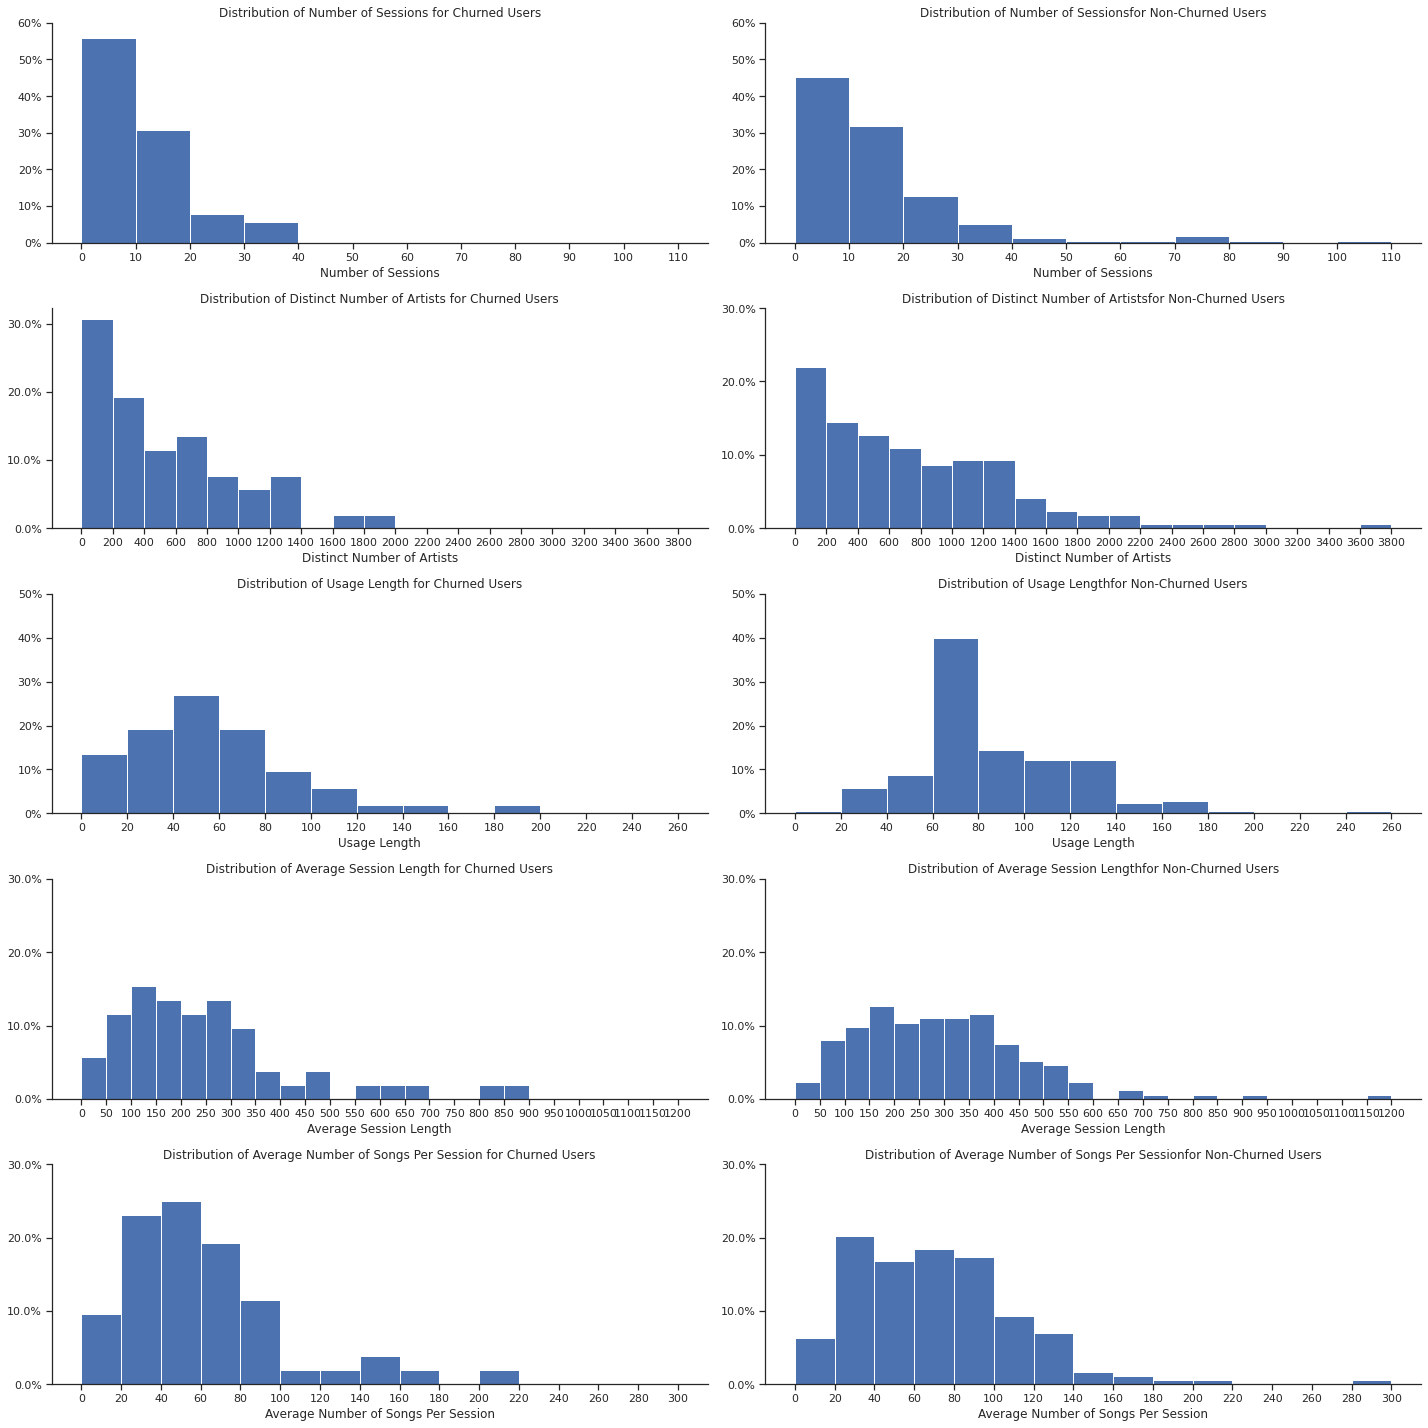

In [30]:
cols_analysis = ['userId','sessions_num','dist_num_artists','avg_session_lgth','song_avg_session','home_avg_session', 
                 'thumbs_up_avg_session', 'thumbs_down_avg_session', 'add_playlist_avg_session', 'add_friend_avg_session', 
                 'settings_avg_session', 'help_avg_session', 'error_avg_session', 'usage_length', 'state', 'gender']
churned_df = user_log.filter(user_log.churned == 1).select(*cols_analysis).dropDuplicates().toPandas()
not_churned_df = user_log.filter(user_log.churned == 0).select(*cols_analysis).dropDuplicates().toPandas()
# Plot the most interesting columns as identified above by inspecting median, mean and standard deviation values
cols_1 = ['sessions_num','dist_num_artists', 'usage_length', 'avg_session_lgth', 'song_avg_session']
title_list_num = ['Number of Sessions', 'Distinct Number of Artists', 'Usage Length', 'Average Session Length',
                  'Average Number of Songs Per Session']
x_incs_1 = [10, 200, 20, 50, 20]
y_max_1 = [0.6, 0.3, 0.5, 0.2, 0.2]
y_incs_1 = [0.1, 0.1, 0.1, 0.1, 0.1]
plot_features(cols_1, 5, churned_df, not_churned_df, x_inc_list = x_incs_1, y_max_list = y_max_1, y_inc_list = y_incs_1,
              title_list = title_list_num)

#### Visualization

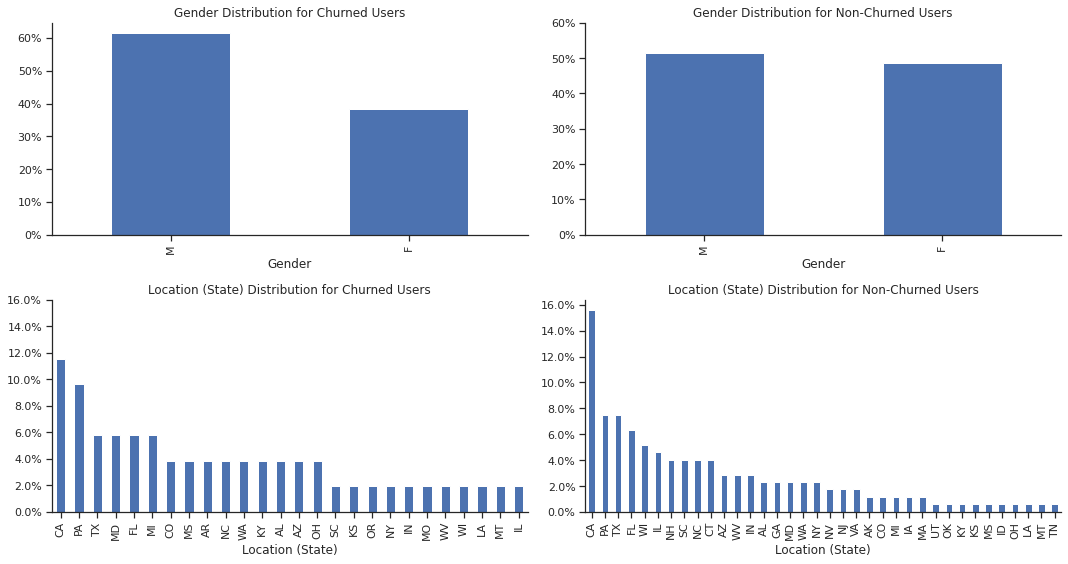

In [31]:
y_max_list = [0.6, 0.16]
y_inc_list = [0.1, 0.02]
qual_cols = ['gender', 'state']
title_list = ['Gender', 'Location (State)']
base_colour = sns.color_palette()[0]
j = 0
plt.figure(figsize = (15,8));
for i in range(2):
    y_max = y_max_list[i]
    y_inc = y_inc_list[i]
    col = qual_cols[i]
    title_colname = title_list[i] 
    
    plt.subplot(2, 2, j+1)
    plt.title(title_colname + ' Distribution for Churned Users')
    churned_df[col].value_counts(normalize = True).plot.bar(x = 'index', y = 'counts', color = sns.color_palette()[0])
    sns.set(style="ticks")
    sns.despine(right=True,top=True)
    plt.yticks(np.arange(0, y_max+y_inc, y_inc))
    plt.xlabel(title_list[i])
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.tight_layout()
    # Save figure as file
    plt.savefig('sparkify_cat_feature_comparison'+str(j+1)+'.png', dpi = 300)
    
    plt.subplot(2, 2, j+2)
    plt.title(title_colname + ' Distribution for Non-Churned Users')
    not_churned_df[col].value_counts(normalize = True).plot.bar(x = 'index', y = 'counts', color = sns.color_palette()[0])
    sns.set(style="ticks")
    sns.despine(right=True,top=True)
    plt.yticks(np.arange(0, y_max+y_inc, y_inc))
    plt.xlabel(title_list[i])
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.tight_layout()
    # Save figure as file
    plt.savefig('sparkify_feature_comparison'+str(j+2)+'.png', dpi = 300)
    j+=2

# Data Preprocessing

## Identifying Class Imbalance

In [32]:
# Reduce data to what we need for our machine learning algorithm
cols_keep = ['userId', 'sessions_num','dist_num_artists', 'usage_length', 'avg_session_lgth', 'song_avg_session','gender',
             'state', 'churned']
model_data = user_log.select(*cols_keep).dropDuplicates()

In [33]:
model_data.head()

Row(userId='200002', sessions_num=6, dist_num_artists=330, usage_length=70.07462962962963, avg_session_lgth=266.39999999999986, song_avg_session=64.5, gender='M', state='WI', churned=0)

## Removing Outliers

In [34]:
numerical_cols = ['sessions_num','dist_num_artists', 'usage_length', 'avg_session_lgth', 'song_avg_session']
bounds = {
    column: dict(
        zip(["q1", "q3"], model_data.approxQuantile(column, [0.25, 0.75], 0))
    )
    for column in numerical_cols
}

# Print the derived bounds
for column in bounds:
    iqr = bounds[column]['q3'] - bounds[column]['q1']
    bounds[column]['lower'] = bounds[column]['q1'] - (iqr * 1.5)
    bounds[column]['upper'] = bounds[column]['q3'] + (iqr * 1.5)
print(bounds)

{'sessions_num': {'q1': 6.0, 'q3': 18.0, 'lower': -12.0, 'upper': 36.0}, 'dist_num_artists': {'q1': 208.0, 'q3': 1089.0, 'lower': -1113.5, 'upper': 2410.5}, 'usage_length': {'q1': 59.125856481481485, 'q3': 100.3783912037037, 'lower': -2.7529456018518417, 'upper': 162.257193287037}, 'avg_session_lgth': {'q1': 161.37708333333367, 'q3': 381.48333333333306, 'lower': -168.78229166666543, 'upper': 711.6427083333322}, 'song_avg_session': {'q1': 35.857142857142854, 'q3': 91.71428571428571, 'lower': -47.92857142857142, 'upper': 175.5}}


In [35]:
# Drop all rows where at least one feature has a value above the upper threshold
for column in bounds:
    upper = bounds[column]['upper']
    model_data = model_data.filter(model_data[column] <= upper)
    print(model_data.count())

214
214
208
202
202


## Scaling


In [39]:
# Create stages list to subsequently call stages when using an ML pipeline later on
stages = []
# Scale numerical features using StandardScaler
assembler_numerical = VectorAssembler(inputCols = numerical_cols, outputCol = 'num_features')
stages += [assembler_numerical]
minmax_scale = MinMaxScaler(inputCol = 'num_features', outputCol= 'num_features_scaled')
stages += [minmax_scale]

## One-hot Encoding

In [41]:
for categoricalCol in ['gender','state']:
    # Use StringIndexer to first index categorical columns
    # In order to ensure consistency in the indexing use alphabetDesc for ordering
    si = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol+'_code', stringOrderType = 'alphabetDesc')
    ohe = OneHotEncoder(inputCols = [si.getOutputCol()], outputCols=[categoricalCol+'_classVec'])
    stages += [si, ohe]

## Transforming & Collecting Data

In [42]:
feature_cols = ['num_features_scaled', 'gender_classVec', 'state_classVec']
assembler = VectorAssembler(inputCols = feature_cols, outputCol = 'features')
stages += [assembler]
# Take care of label column churned using StringIndexer
label_indexer = StringIndexer(inputCol= 'churned', outputCol = 'label')
stages += [label_indexer]

In [45]:

# Convert the stages contained in list into a pipeline, fit and apply the pipeline to obtain the converted data
data_prep_pipeline = Pipeline().setStages(stages) 
data_prep_model = data_prep_pipeline.fit(model_data)
model_data_prep = data_prep_model.transform(model_data)

## Train/test split

In [47]:
train, test = model_data_prep.randomSplit([0.7, 0.3], seed = 42)

# Model Selection

In [ ]:
lr =  LogisticRegression()

paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0,1]) \
    .addGrid(lr.regParam, [0, 0.1]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)
lr_model = crossval.fit(train)
results_lr_train = lr_model.transform(train)
results_lr_test = lr_model.transform(test)


rf = RandomForestClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)
rf_model = crossval.fit(train)
results_rf_train = rf_model.transform(train)
results_rf_test = rf_model.transform(test)

gbt = GBTClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 30]) \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .build()

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)
gbt_model = crossval.fit(train)
results_gbt_train = gbt_model.transform(train)
results_gbt_test = gbt_model.transform(test)

In [ ]:
def calculate_f1(results):
    """Given a table of pyspark.ml.model.transform results, the function calculates and returns the F1 score."""
    true_positives = results.filter("label = 1 and prediction = 1").count()
    false_positives = results.filter("label = 0 and prediction = 1").count()
    false_negatives = results.filter("label = 1 and prediction = 0").count()
    precision = true_positives / (true_positives + false_positives) 
    recall = true_positives / (true_positives + false_negatives)
    f1 = 2 * precision * recall / (precision + recall)
    
    return f1
    
results_df = pd.DataFrame({'score': [calculate_f1(results_lr_train), calculate_f1(results_rf_train),
                                      calculate_f1(results_gbt_train), calculate_f1(results_lr_test),
                                      calculate_f1(results_rf_test), calculate_f1(results_gbt_test)],
                           'dataset': ['Train', 'Train', 'Train', 'Test', 'Test', 'Test'],
                           'model': ['LogisticRegression', 'RandomForest', 'GradientBoosting',
                                     'LogisticRegression', 'RandomForest', 'GradientBoosting']})

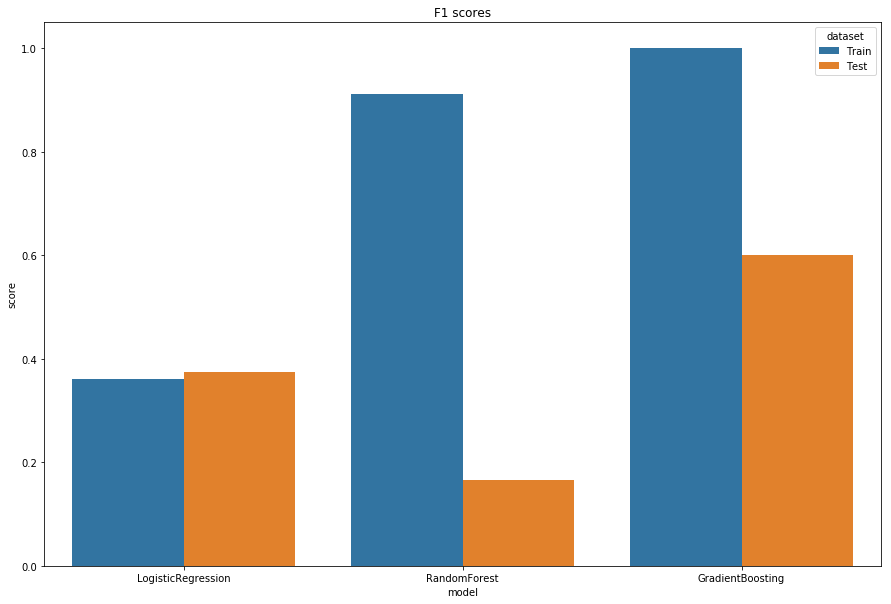

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(x='model', y='score', hue='dataset', data=results_df)
plt.title('F1 scores')
plt.show()

In [ ]:
print('F1 score in Logistic Regression model in trainset: ',  calculate_f1(results_lr_train))
print('F1 score in Logistic Regression model in testset: ', calculate_f1(results_lr_test))
print('F1 score in Random Forest model in trainset: ', calculate_f1(results_rf_train))
print('F1 score in Random Forest model in testset: ', calculate_f1(results_rf_test))
print('F1 score in Gradient Boosting model in trainset: ', calculate_f1(results_gbt_train))
print('F1 score in Gradient Boosting model in testset: ', calculate_f1(results_gbt_test))

F1 score in Logistic Regression model in trainset:  0.36065573770491804
F1 score in Logistic Regression model in testset:  0.375
F1 score in Random Forest model in trainset:  0.9113924050632911
F1 score in Random Forest model in testset:  0.16666666666666666
F1 score in Gradient Boosting model in trainset:  1.0
F1 score in Gradient Boosting model in testset:  0.6


## Hyperparameter Tuning

In [ ]:
gbt = GBTClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, np.arange(10, 30, 10)) \
    .addGrid(gbt.maxDepth, np.arange(3, 7, 1)) \
    .addGrid(gbt.minInstancesPerNode, [1, 10, 20]) \
    .build()

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)
gbt_model_refined = crossval.fit(train)
results_gbt = gbt_model_refined.transform(test)
results_gbt_tr = gbt_model_refined.transform(train)

In [ ]:
print('F1 score in Gradient Boosting model in trainset: ', calculate_f1(results_gbt_tr))
print('F1 score in Gradient Boosting model in testset: ', calculate_f1(results_gbt))

F1 score in Gradient Boosting model in trainset:  0.8
F1 score in Gradient Boosting model in testset:  0.4800000000000001


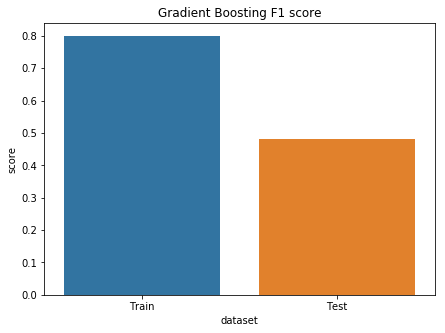

In [ ]:
results_df = pd.DataFrame({'score': [calculate_f1(results_gbt_tr), calculate_f1(results_gbt)],
                           'dataset': ['Train', 'Test']})
plt.figure(figsize=(7,5))
sns.barplot(x='dataset', y='score', data=results_df)
plt.title('Gradient Boosting F1 score')
plt.show()

## Feature Importance

In [ ]:
feature_importances_df = pd.DataFrame(gbt_model.featureImportances.toArray())
feature_importances_df['index'] = feature_importances_df.index
# Rename column containing feature importances
feature_importances_df = feature_importances_df.rename(columns = {0:'feature_importance'})
feature_importances_df = feature_importances_df.sort_values(by = 'feature_importance', ascending = False)
# Reset the index of the feature_importances dataframe
feature_importances_df = feature_importances_df.reset_index(drop = True)
# obtain a dictionary with names for feature importances
features_df = pd.DataFrame(train.schema["features"].metadata["ml_attr"] 
["attrs"]["binary"]+train.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")
# adjust names of numerical features using replace and a dictionary
numerical_feat_dict = {'num_features_scaled_0':numerical_cols[0],'num_features_scaled_1':numerical_cols[1],
                      'num_features_scaled_2':numerical_cols[2], 'num_features_scaled_3':numerical_cols[3],
                      'num_features_scaled_4':numerical_cols[4]}
features_df['name'] = features_df['name'].replace(numerical_feat_dict)
# Remove classVec in categorical feature names
features_df['name'] = features_df['name'].str.replace('classVec_','')
feature_dict = dict(zip(features_df["idx"],features_df["name"]))
# Use this dictionary to add a column containing the feature names
feature_importances_df['feature'] = feature_importances_df['index'].replace(feature_dict)
# Add column with cumulative sum of feature importances to be used in plot
feature_importances_df['cum_feat_importance'] = feature_importances_df['feature_importance'].cumsum()
feature_importances_df.head()

In [ ]:
gbt_model.bestModel.featureImportances